In [1]:
import numpy as np
import json, os, sys, glob
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping
tf.keras.backend.clear_session()

cur_path=os.getcwd()
sys.path.append(cur_path)

parent_path=os.path.abspath(os.path.join(cur_path,'..'))
sys.path.append(parent_path)

### Load Data

In [2]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import load_sig_tensor

folder_path = r'C:\Users\MichaelB9\Documents\POSA data\S9 AHI\json_files\preprocessed'

target_signal='Position'
input_signals=['Flow', 'Mask Pres']

json_files = glob.glob(os.path.join(folder_path,'*.json'))

sig_tensor, target_tensor, subject_names = load_sig_tensor(
    json_files,epoch_size = 60,epoch_step = 60,
    sample_rate = 25, input_signals=input_signals,
    target_signal=target_signal,
    dataset='s9',
    )

### Plot octave encoded signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


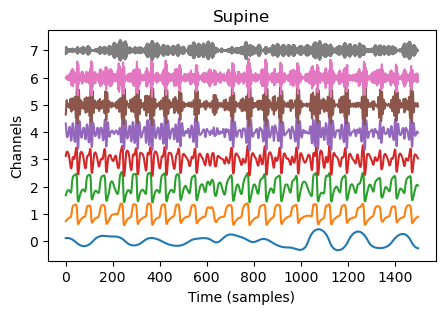

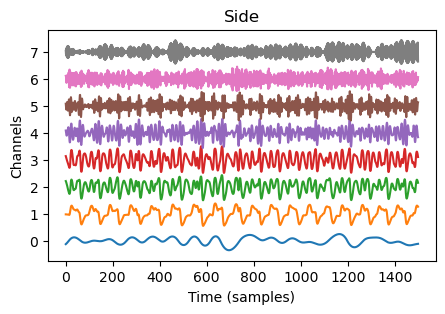

In [6]:
%load_ext autoreload
%autoreload 2
from helpers.plotting import plot_oct

plot_oct(sig_tensor['Flow'][:,3,:],np.where(target_tensor[3]==1,'Supine','Side'))
plot_oct(sig_tensor['Flow'][:,300,:],np.where(target_tensor[300]==1,'Supine','Side'))


## Train a standard 1d CNN

### Split the data

In [3]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import split

X_train, y_train, X_val, y_val, X_test, y_test = split(sig_tensor['Flow'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  127  subjects
Validation Set Size =  11  subjects
Test Set Size =  12  subjects
------------------------------
train set size =  (92872, 1500, 8) 
 Target distribution 
 1    0.515613
0    0.484387
dtype: float64
------------------------------
val set size =  (8110, 1500, 8) 
 Target distribution 
 1    0.54439
0    0.45561
dtype: float64
------------------------------
test set size =  (9324, 1500, 8) 
 Target distribution 
 1    0.536143
0    0.463857
dtype: float64
------------------------------


In [4]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()

from build_dnns import build_cnn_1D

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=4,
    mode='auto',
    restore_best_weights=True)

# Build model
cnn_model=build_cnn_1D(X_train.shape[1],X_train.shape[2],filters=16,kernel_size=16,n_dense=16,dropout=0.3)
# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])
# Fit model
H=cnn_model.fit(
    X_train,y_train,
    epochs=5,batch_size=128,
    shuffle=True,validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/5
726/726 [==============================] - 55s 74ms/step - loss: 0.6767 - accuracy: 0.5632 - val_loss: 0.6335 - val_accuracy: 0.6905
Epoch 2/5
726/726 [==============================] - 57s 78ms/step - loss: 0.5914 - accuracy: 0.6903 - val_loss: 0.6211 - val_accuracy: 0.6702
Epoch 3/5
726/726 [==============================] - 56s 77ms/step - loss: 0.5578 - accuracy: 0.7175 - val_loss: 0.6040 - val_accuracy: 0.6874
Epoch 4/5
726/726 [==============================] - 57s 79ms/step - loss: 0.5421 - accuracy: 0.7313 - val_loss: 0.5824 - val_accuracy: 0.7009
Epoch 5/5
726/726 [==============================] - 57s 78ms/step - loss: 0.5310 - accuracy: 0.7391 - val_loss: 0.6134 - val_accuracy: 0.6842


### Model Evaluation

292/292 [==============================] - 1s 3ms/step


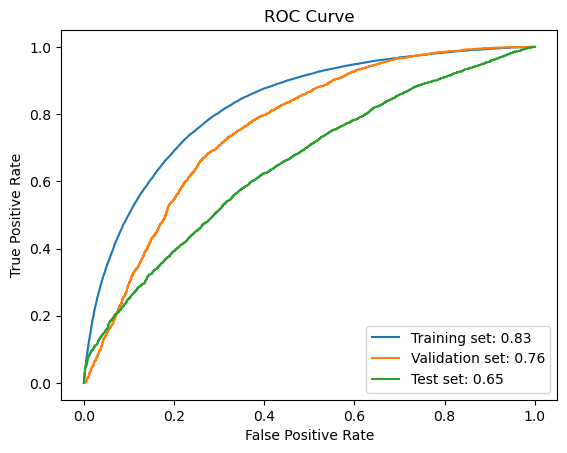

In [7]:
from helpers.plotting import train_val_curve, plot_roc
from sklearn.metrics import *


y_train_pred=cnn_model.predict(X_train)
y_val_pred=cnn_model.predict(X_val)
y_test_pred=cnn_model.predict(X_test)

plt.figure()
plot_roc(y_train,y_train_pred,0.5, label='Training set')
plot_roc(y_val,y_val_pred,0.5, label='Validation set')
plot_roc(y_test,y_test_pred,0.5, label='Test set')

In [8]:
print(classification_report(y_val,sp.ndimage.median_filter(y_val_pred,15)>0.7))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      3695
           1       0.74      0.70      0.72      4415

    accuracy                           0.71      8110
   macro avg       0.71      0.71      0.71      8110
weighted avg       0.71      0.71      0.71      8110



## Train a multiheaded model with Flow and Pressure

In [9]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import split

Xflow_train, y_train, Xflow_val, y_val, Xflow_test, y_test = split(sig_tensor['Flow'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)
Xpres_train, _, Xpres_val, _, Xpres_test, _ = split(sig_tensor['Mask Pres'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  127  subjects
Validation Set Size =  11  subjects
Test Set Size =  12  subjects
------------------------------
train set size =  (92872, 1500, 8) 
 Target distribution 
 1    0.515613
0    0.484387
dtype: float64
------------------------------
val set size =  (8110, 1500, 8) 
 Target distribution 
 1    0.54439
0    0.45561
dtype: float64
------------------------------
test set size =  (9324, 1500, 8) 
 Target distribution 
 1    0.536143
0    0.463857
dtype: float64
------------------------------
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  127  subjects
Validation Set Size =  11  subjects
Test Set Size =  12  subjects
------------------------------
train set size =  (92872, 1500, 8) 
 Target distribution 
 1    0.515613
0  

In [11]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()
from build_dnns import build_2head_cnn

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=4,
    mode='auto',
    restore_best_weights=True)

cnn_model2head=build_2head_cnn(Xflow_train.shape[1],Xflow_train.shape[2],filters=16,kernel_size=16,n_dense=16,dropout=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model2head.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])

H=cnn_model2head.fit(
    [Xflow_train,Xpres_train],y_train, 
    epochs=15,batch_size=64,
    shuffle=True,validation_data=([Xflow_val,Xpres_val],y_val), 
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/15
1452/1452 [==============================] - 109s 73ms/step - loss: 0.6949 - accuracy: 0.5149 - val_loss: 0.6921 - val_accuracy: 0.5444
Epoch 2/15
1452/1452 [==============================] - 102s 70ms/step - loss: 0.6928 - accuracy: 0.5156 - val_loss: 0.6915 - val_accuracy: 0.5444
Epoch 3/15
1261/1452 [=========================>....] - ETA: 12s - loss: 0.6927 - accuracy: 0.5155

KeyboardInterrupt: 

### Model Evaluation

In [ ]:
from helpers.plotting import train_val_curve, plot_roc
from sklearn.metrics import *

train_val_curve(H)

y_train_pred=cnn_model.predict(X_train)
y_val_pred=cnn_model.predict(X_val)
y_test_pred=cnn_model.predict(X_test)

plt.figure()
plot_roc(y_train,y_train_pred, label='Training set')
plot_roc(y_val,y_val_pred, label='Validation set')
plot_roc(y_test,y_test_pred, label='Test set')

In [ ]:
print(classification_report(y_val,sp.ndimage.median_filter(y_val_pred,15)>0.65))